<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/sparse_rasterization_3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [1]:
import torch
import scipy.ndimage
import numpy as np
from scipy.spatial.transform import Rotation as R
from torch import transpose
import matplotlib.pyplot as plt


# psdueo-atom point cloud

In [2]:
sigma = 2
n_trunc = 6*sigma
n_atoms = 100
n_batch = 4
n_pix = 64
dim = 3

In [3]:
torch.random.manual_seed(0)
max_angle = 90
angles = np.linspace(0,max_angle,n_batch)

atom_centers_gt_batch = 0.5*(n_pix*torch.rand(n_atoms, dim) - n_pix//2)
dim_project = 3
rotations = torch.from_numpy(R.from_euler('z', angles, degrees=True).as_matrix()[:,:dim_project,:dim_project]).float()
atom_centers_gt_batch = torch.matmul(atom_centers_gt_batch[:,:dim_project].reshape(n_atoms,1,1,dim_project), rotations.reshape(1,n_batch,dim_project,dim_project)).reshape(n_atoms,n_batch,dim_project).transpose(1,2)
atom_centers_gt_batch.shape

torch.Size([100, 3, 4])

# 3D -> 2D fast projection

In [4]:
def precompute_project_vec_batch(n_trunc, sigma, n_atoms, n_batch):
  nt_ = (n_trunc - 1) // 2
  a = -1 / (2 * sigma * sigma)
  pix_patch = torch.arange(-nt_, nt_+1)
  _, patch_mesh = torch.meshgrid(pix_patch,pix_patch, indexing='xy') # 'ij' default dec 2022, but can remove soon: warning for update

  len_pix_patch = len(pix_patch)

  n_pix_patch_atoms = len_pix_patch**2*n_atoms
  xy_batch_idx = torch.empty(2, n_pix_patch_atoms*n_batch)
  batch_idx = torch.repeat_interleave(torch.arange(n_batch),n_pix_patch_atoms)
  xy_batch_idx[1] = batch_idx

  return patch_mesh, a, nt_, xy_batch_idx

patch_mesh, a, nt_, xy_batch_idx = precompute_project_vec_batch(n_trunc, sigma, n_atoms, n_batch)

In [5]:
def project_vec_batch(patch_mesh, xy_batch_idx, n_pix, n_batch, atom_centers_gt_batch, a):
  mx = patch_mesh
  n_atoms = len(atom_centers_gt_batch)
  n_trunc = len(mx)
  c = (atom_centers_gt_batch + n_pix // 2)
  c_bar = c.round().long()
  d = c - c_bar
  my = mx.T
  mxp, myp = d[:, 0][None, None, ...] - mx[... ,None, None], d[:, 1][None, None, ...] - my[..., None, None] # n_trunc,n_trunc,n_atoms,n_batch
  density = torch.exp(a * (mxp*mxp + myp*myp))
  mxi, myi = c_bar[:, 0][None, None, ...] + mx[...,None,None], c_bar[:, 1][None, None, ...] + my[..., None, None]
  idx = (mxi % n_pix)*n_pix + (myi % n_pix)
  xy_batch_idx[0] = transpose(idx.reshape(n_trunc*n_trunc, n_atoms, n_batch), 0, -1).flatten()
  sp_unc = torch.sparse_coo_tensor(
      indices=xy_batch_idx,
      values=transpose(density.reshape(n_trunc*n_trunc, n_atoms, n_batch), 0, -1).flatten(),
      size=(n_pix*n_pix, n_batch)
      )
  sp_c = sp_unc.coalesce()
  fast_proj = transpose(sp_c.to_dense(), 0, -1)

  return fast_proj

clean_signal = project_vec_batch(patch_mesh, xy_batch_idx, n_pix, n_batch, atom_centers_gt_batch[:,:dim_project], a).reshape(n_batch,n_pix,n_pix)


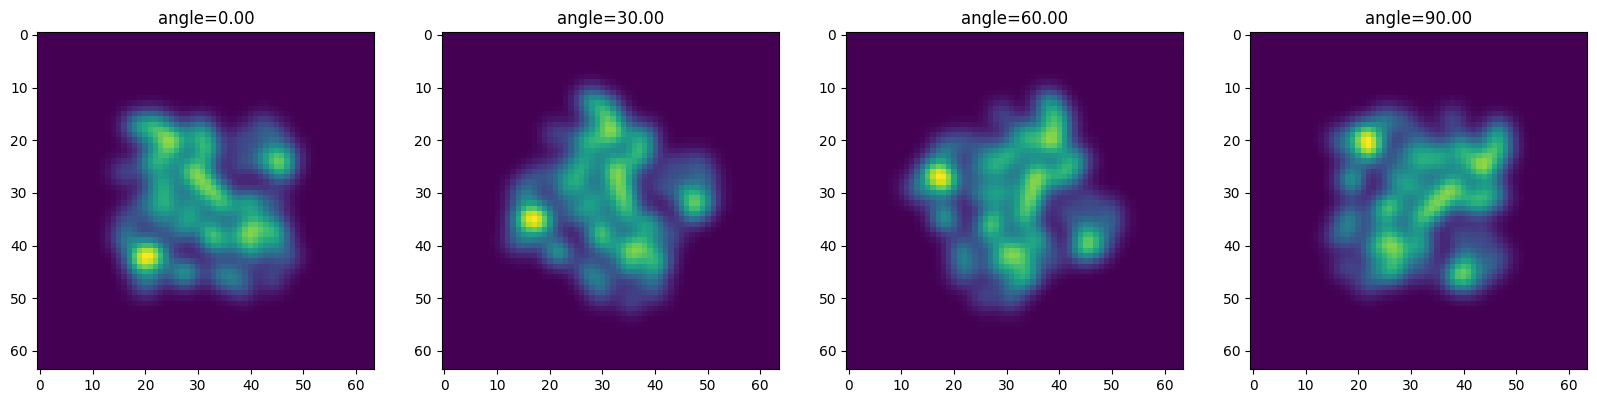

In [6]:
n_plots = n_batch
fig, axes = plt.subplots(1, n_plots, figsize=(5*n_plots, 5))
for i in range(n_batch):
  axes[i].imshow(clean_signal[i])
  axes[i].set_title('angle={:1.2f}'.format(angles[i]))



# 3D coordinates -> 3D volume (sparse rasterization)

In [7]:
def precompute_project_vec_batch_3d(n_trunc, sigma, n_atoms, n_batch,dev):
  nt_ = (n_trunc - 1) // 2 # 2
  a = -1 / (2 * sigma * sigma)
  pix_patch = torch.arange(-nt_, nt_+1).to(dev) # len 5
  dim = 3
  _, patch_mesh, _ = torch.meshgrid(pix_patch,pix_patch,pix_patch, indexing='xy') # 'ij' default dec 2022, but can remove soon: warning for update

  len_pix_patch = len(pix_patch) # 5

  n_pix_patch_atoms = len_pix_patch**dim*n_atoms # 125*10=1250
  xyz_batch_idx = torch.empty(2, n_pix_patch_atoms*n_batch).to(dev) # 1250*4 = 5000
  batch_idx = torch.repeat_interleave(torch.arange(n_batch),n_pix_patch_atoms)
  xyz_batch_idx[1] = batch_idx

  return patch_mesh, a, nt_, xyz_batch_idx

patch_mesh, a, nt_, xyz_batch_idx = precompute_project_vec_batch_3d(n_trunc, sigma, n_atoms, n_batch, 'cpu')

In [8]:
def project_vec_batch_3d(patch_mesh, xyz_batch_idx, n_pix, n_batch, atom_centers_gt_batch, a):
  mx = patch_mesh
  n_atoms = len(atom_centers_gt_batch)
  n_trunc = len(mx)
  c = (atom_centers_gt_batch + n_pix // 2)
  c_bar = c.round().long()
  d = c - c_bar
  my = mx.transpose(0,1)
  mz = mx.transpose(0,2)

  mxp = d[:, 0][None, None, ...] - mx[... ,None, None] # n_trunc,n_trunc,n_atoms,n_batch
  myp = d[:, 1][None, None, ...] - my[..., None, None]
  mzp = d[:, 2][None, None, ...] - mz[..., None, None]
  density = torch.exp(a * (mxp*mxp + myp*myp + mzp*mzp))
  mxi = c_bar[:, 0][None, None, ...] + mx[...,None,None]
  myi = c_bar[:, 1][None, None, ...] + my[..., None, None]
  mzi = c_bar[:, 2][None, None, ...] + mz[..., None, None]
  idx = n_pix*(n_pix*(mxi % n_pix) + (myi % n_pix)) + (mzi % n_pix)
  xyz_batch_idx[0] = transpose(idx.reshape(n_trunc*n_trunc*n_trunc, n_atoms, n_batch), 0, -1).flatten()
  projection_value = transpose(density.reshape(n_trunc*n_trunc*n_trunc, n_atoms, n_batch), 0, -1).flatten()
  sp_unc = torch.sparse_coo_tensor(
      indices=xyz_batch_idx,
      values=projection_value,
      size=(n_pix*n_pix*n_pix, n_batch)
      )
  sp_c = sp_unc.coalesce()
  rasterized_volume = transpose(sp_c.to_dense(), 0, -1)

  return rasterized_volume


rasterized_volume = project_vec_batch_3d(patch_mesh, xyz_batch_idx, n_pix, n_batch, atom_centers_gt_batch, a).reshape(n_batch,n_pix,n_pix,n_pix)


In [9]:
def normalize_residual(image1,image2):
  return 100*np.abs(normalize(image1)-normalize(image2))

def normalize(image):
  image /= image.mean()
  return image

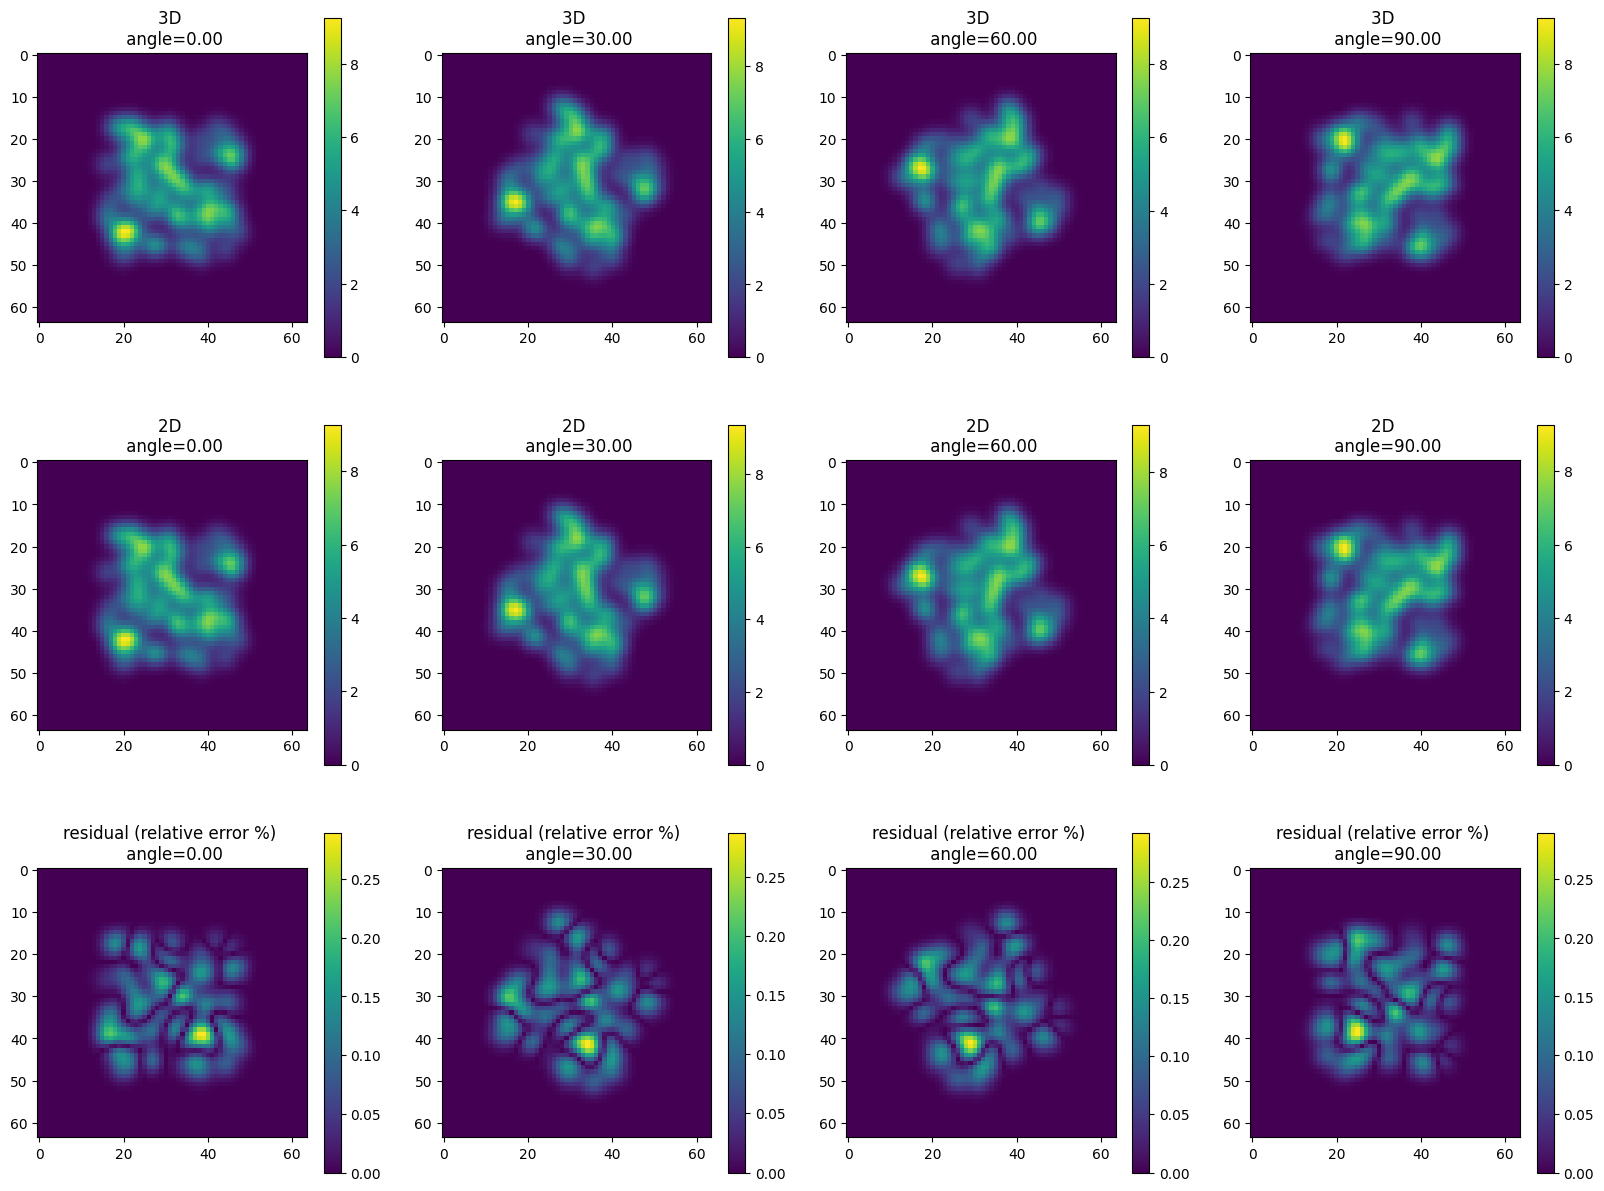

In [10]:
n_plots = n_batch
base_size = 5
n_rows = 3
fig, axes = plt.subplots(n_rows, n_plots, figsize=(base_size*n_plots, base_size*n_rows))

for i in range(n_batch):
  axes[0,i].imshow(normalize(rasterized_volume.sum(-1)[i]))
  axes[0,i].set_title('3D \n angle={:1.2f}'.format(angles[i]))
  cb = plt.colorbar(axes[0,i].images[0], ax=axes[0,i])

  axes[1,i].imshow(normalize(clean_signal[i]))
  axes[1,i].set_title('2D \n angle={:1.2f}'.format(angles[i]))
  cb = plt.colorbar(axes[1,i].images[0], ax=axes[1,i])

  residual = normalize_residual(clean_signal[i].numpy(),rasterized_volume.sum(-1)[i].numpy())
  axes[2,i].imshow(residual)
  axes[2,i].set_title('residual (relative error %) \n angle={:1.2f}'.format(angles[i]))
  cb = plt.colorbar(axes[2,i].images[0], ax=axes[2,i])


# numerical agreement between projection and rasterization
* Check if the projection agrees with the rasterization (summing along projection axis after making it densely in 3D)

In [40]:
sigma = 1
n_trunc = 6*sigma
n_atoms = 3000
n_batch = 100
n_pix = 64
dim = 3

dev = 'cuda'

In [41]:
torch.random.manual_seed(0)
max_angle = 90
angles = np.linspace(0,max_angle,n_batch)

atom_centers_gt_batch = 0.5*(n_pix*torch.rand(n_atoms, dim) - n_pix//2).to(dev)
dim_project = 3
rotations = torch.from_numpy(R.from_euler('z', angles, degrees=True).as_matrix()[:,:dim_project,:dim_project]).float().to(dev)
atom_centers_gt_batch = torch.matmul(atom_centers_gt_batch[:,:dim_project].reshape(n_atoms,1,1,dim_project), rotations.reshape(1,n_batch,dim_project,dim_project)).reshape(n_atoms,n_batch,dim_project).transpose(1,2)
atom_centers_gt_batch.shape

torch.Size([3000, 3, 100])

In [42]:
%%time

patch_mesh, a, nt_, xyz_batch_idx = precompute_project_vec_batch_3d(n_trunc, sigma, n_atoms, n_batch, dev)

CPU times: user 152 ms, sys: 285 ms, total: 437 ms
Wall time: 435 ms


In [43]:
import time
n_trials = 20
run_times_list = []

for _ in range(n_trials):
  start = time.time()
  rasterized_volume = project_vec_batch_3d(patch_mesh, xyz_batch_idx, n_pix, n_batch, atom_centers_gt_batch, a)
  finish = time.time()
  run_time_ms = finish-start
  run_times_list.append(run_time_ms)
run_times = np.array(run_times_list)
print('runtime av {:1.2e} +/- {:1.2e}'.format(run_times.mean(),run_times.std()))

runtime av 2.46e-01 +/- 6.46e-04


In [44]:
print('runtime (s) mean={:1.3e} +/- std={:1.3e} | n_batch={:} | n_atom={:} | n_pix={:}'.format(run_times.mean(),run_times.std(),n_batch,n_atoms,n_pix))
print('{:1.3f} ms per volume in batch'.format(run_times.mean()*1e3/n_batch))

runtime (s) mean=2.464e-01 +/- std=6.460e-04 | n_batch=100 | n_atom=3000 | n_pix=64
2.464 ms per volume in batch
